In [17]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import os
# Make sure we're in the right directory
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [5]:
import xarray as xr
import numpy as np
from typing import *
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from aibedo.utilities.plotting import data_snapshots_plotting, data_mean_plotting
from aibedo.utilities.wandb_api import reload_checkpoint_from_wandb

In [18]:
plt.rcParams['figure.figsize'] = [80, 15]  # general matplotlib parameters
plt.rcParams['figure.dpi'] = 120 

In [7]:
num_workers = 2
predict_set = "val"  #  use 'same_as_test' to predict on test set, 'val' means that predictions are made on the validation set (here, CESM2)
DATA_DIR = "./data"

overrides = [f'datamodule.num_workers={num_workers}',
             f'++datamodule.prediction_data={predict_set}',
             'datamodule.eval_batch_size=5',
             'verbose=False',
             f'datamodule.data_dir={DATA_DIR}'
            ]

In [8]:
cur_run_id = None
def get_model_and_dm_from_run_id(run_id):
    global cur_run_id
    cur_run_id = run_id
    values = reload_checkpoint_from_wandb(run_id=run_id, project='AIBEDO', override_key_value=overrides, try_local_recovery=False)
    return  values['model'], values['datamodule'], values['config']

In [9]:
def get_predictions_xarray(run_id, split='predict', return_normalized_outputs=False, variables='all'):
    model, dm, cfg = get_model_and_dm_from_run_id(run_id)
    print('physics_loss_weights:', cfg.model.physics_loss_weights)
    dm.setup(stage=split)
    dataloader = dm.val_dataloader() if 'val' in split else dm.predict_dataloader()
    predictions_xarray = dm.get_predictions_xarray(model, dataloader=dataloader, return_normalized_outputs=return_normalized_outputs, variables=variables)
    del model, dm, cfg
    return predictions_xarray

# Reload and predict with some models:
#### Baseline MLP, without any constraints

In [10]:
rid_baseline = "37tl5tsy"
# ds_mlp = get_predictions_xarray(rid_baseline, split='predict')
ds_mlp = xr.open_dataset(DATA_DIR.replace('data', 'out_dir/preds/') + rid_baseline + '.nc')

#### MLP with all constraints

In [11]:
rid_all= "34q3echu"
# ds_c_all = get_predictions_xarray(rid_all, split='predict')
ds_c_all = xr.open_dataset(DATA_DIR.replace('data', 'out_dir/preds/') + rid_all + '.nc')

In [12]:
snapshots = [1, 10, -50, -45, -38, -36]   # which timesteps to plot
pkwargs = dict(snapshots_to_plot=snapshots, same_colorbar_for_preds_and_targets=False, robust=False, marker_size=1, coastlines_linewidth=0.5)  # plotting kwargs

# Global maps


The predictions are for 6 arbitrary snapshots of the ERA5 test set
- First row: Targets 
- 2nd row: Predictions of MLP without constraints

#### Surface pressure

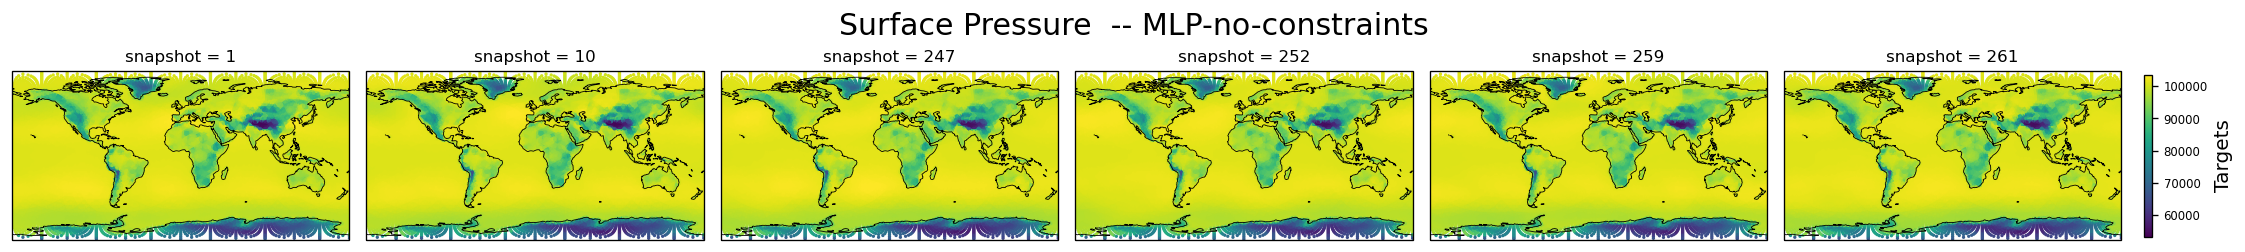

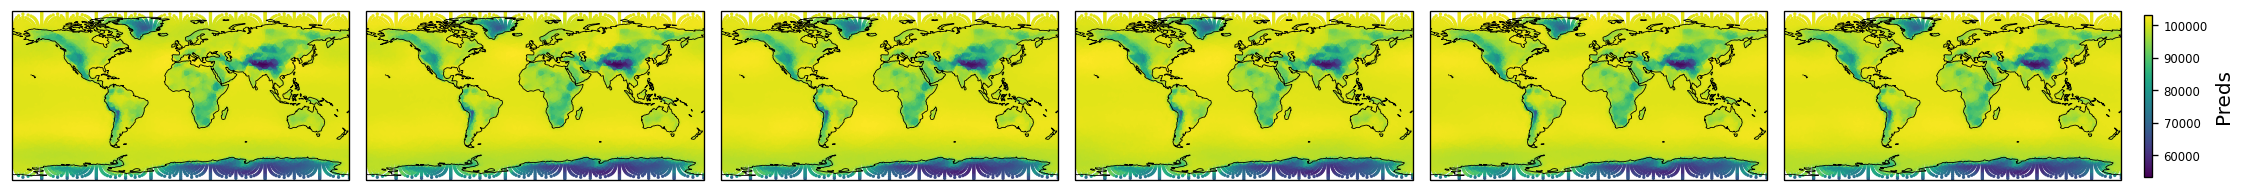

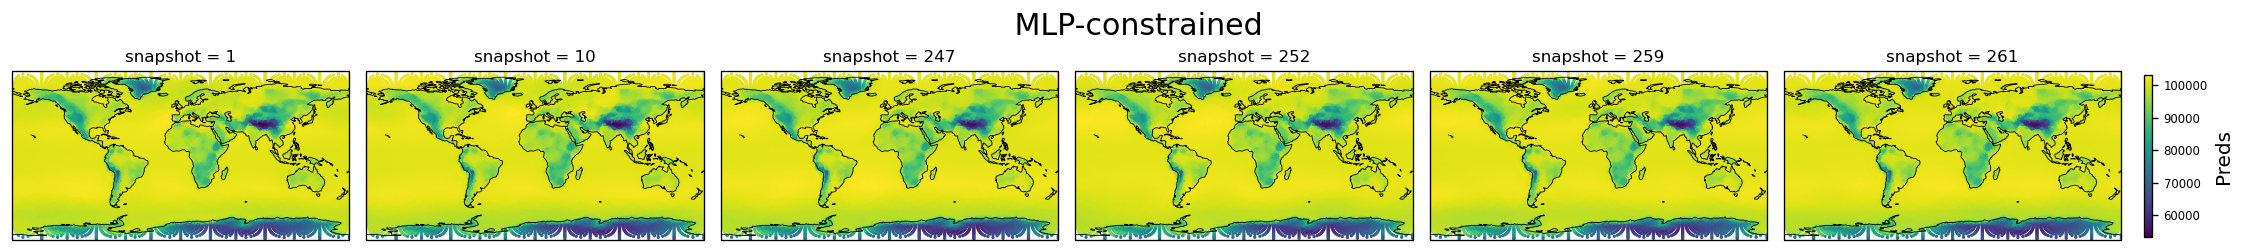

In [19]:
var= 'ps'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

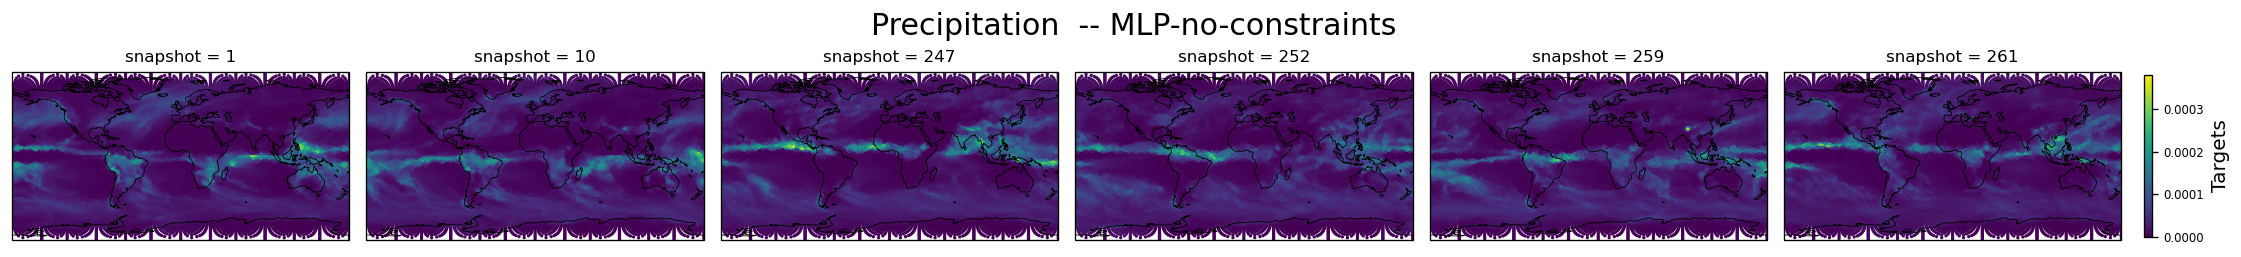

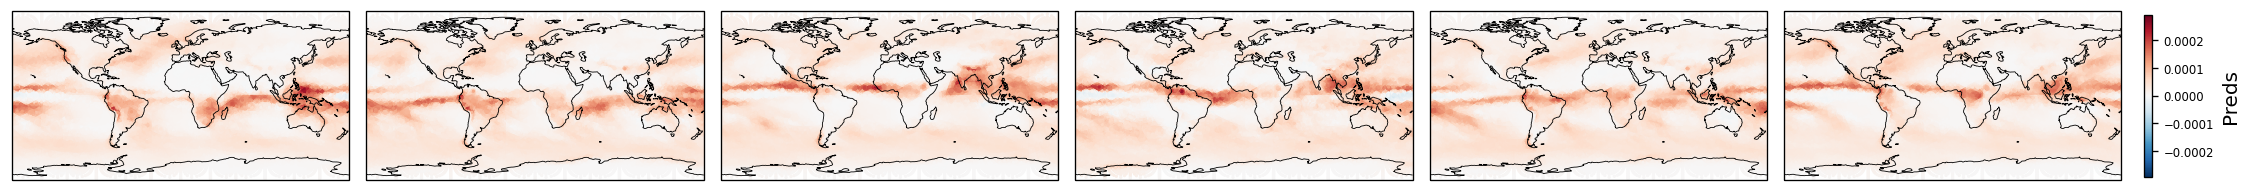

In [ ]:
var= 'pr'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

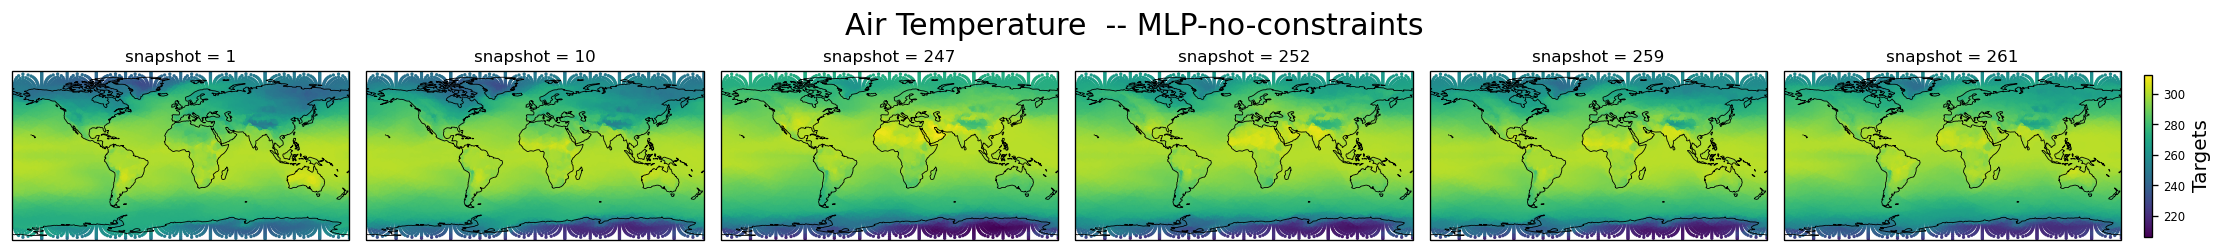

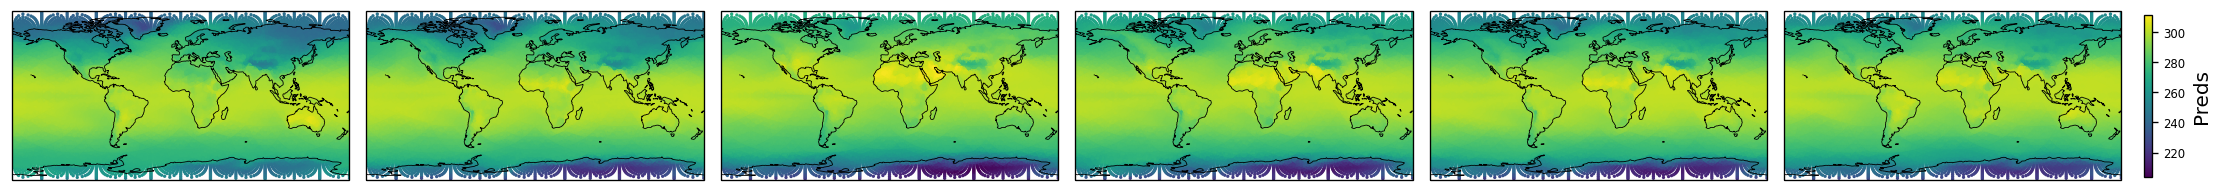

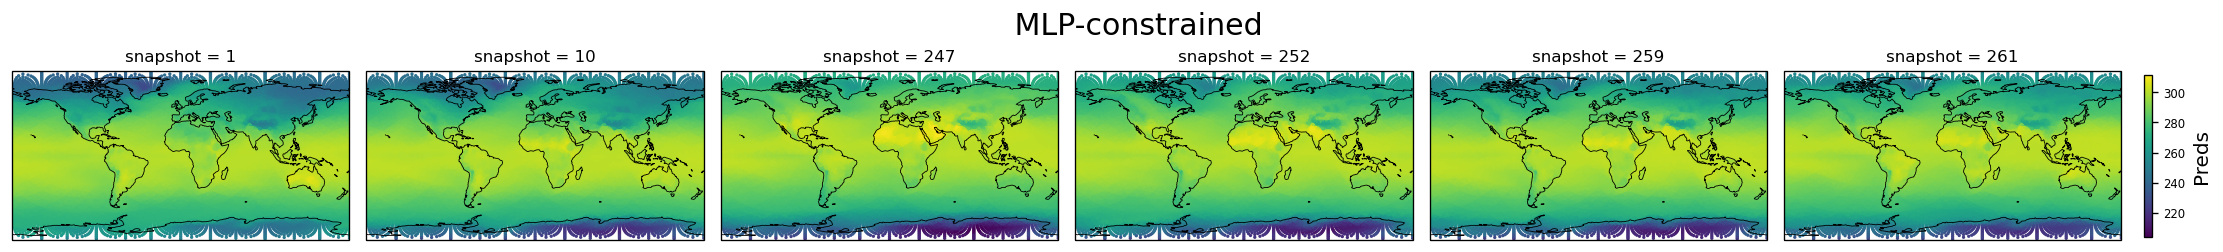

In [20]:
var= 'tas'
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", plot_error=False, cmap=None, **pkwargs, vars_to_plot=[var])
_ = data_snapshots_plotting(ds_c_all, title=" MLP-constrained", plot_only_preds=True, cmap=None, **pkwargs, vars_to_plot=[var])

## Plot errors
#### First, surface pressure

In [ ]:
var= 'ps'
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn1, title=" MLP-nn1", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn2, title=" MLP-nn2", cmap=None, **pkwargs2)

#### Temperature

In [ ]:
var= 'tas'
for ds in [ds_mlp, ds_nn1, ds_nn2]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn1, title=" MLP-nn1", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn2, title=" MLP-nn2", cmap=None, **pkwargs2)

In [ ]:
var= 'pr'
for ds in [ds_mlp, ds_nn1, ds_nn2]:
    ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']
pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='bias')}
_ = data_snapshots_plotting(ds_mlp, title=" -- MLP-no-constraints", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn1, title=" MLP-nn1", cmap=None, **pkwargs2)
_ = data_snapshots_plotting(ds_nn2, title=" MLP-nn2", cmap=None, **pkwargs2)

In [ ]:
for var in ['ps', 'tas']:
    ds_nn2[f'{var}_diff_to_base_pred'] = ds_mlp[f'{var}_preds'] - ds_nn2[f'{var}_preds']
    pkwargs2 = {**pkwargs.copy(), **dict(vars_to_plot=[var], data_to_plot=['error'], error_to_plot='diff_to_base_pred')}
    _ = data_snapshots_plotting(ds_nn2, title=" MLP-nn2", cmap=None, **pkwargs2)

## Temporal mean

In [ ]:
for var in ['pr', 'tas', 'ps']:
    for ds in [ds_mlp, ds_nn1, ds_nn2]:
        ds[f'{var}_mae'] = np.abs(ds[f'{var}_preds'] - ds[f'{var}_targets'])
        ds[f'{var}_bias'] = ds[f'{var}_preds'] - ds[f'{var}_targets']

pkwargs3 = dict(vars_to_plot="denormalized", error_to_plot='mae')
_ = data_mean_plotting(ds_mlp, **pkwargs3)
_ = data_mean_plotting(ds_nn1,  **pkwargs3, plot_only_errors=True)
_ = data_mean_plotting(ds_nn2,  **pkwargs3, plot_only_errors=True)